In [1]:
import numpy as np

In [2]:
def softmax(x, axis=0):
    """
    Calculate Softmax function for an array x along a specified axis.
    
    axis=0 calculates softmax across rows while means each column sums to 1.
    axis=1 calculates softmax across columns which means each row sums to 1.
    """
    return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis=axis), axis)

1. Calculating alignment scores

The first step is to calculate the alignmnet scores.

This is a measure of similarity between the decoder hidden state and each encoder hidden state.

From the paper, this operation is:

$e_{ij} = v^{T}_{a} \tanh (W_aS_{i-1} + U_ah_j)$

where 

* $W_a$, $U_a$ and $v_a$ are weight matrices and $n$ is the hiden state size.

In practice, it's implemented as a feedforward neural network with 2 layers, where $m$ is the size of the layers in the alignmnet network. It looks something like:

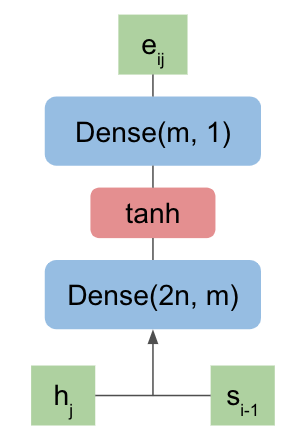

Here $h_j$ are the encoder hidden states for each input step $j$ and $s_{i-1}$ is the decoder hidden state of the previous step.

The first layer corresponds to $W_a$ and $U_a$ while the second layer corresponds to $v_a$

To implement this, concatenate the encoder and decoder hidden states to produce an array with size K X 2n where K is the number of encoder states/steps.

For this, use `np.concatenate`.

There is only one decoder state, so you'll need to reshape it to successfully concatenate the arrays.

The eaisest way to use `decoder_state.repeat` to match the hiden state array size.

Then, apply the first layer as a matrix multiplication between the weight sand the concatenated input.

Use the tan function to get the activations.

Compute the matrix multiplicateion of the second layer weights and the activations. This returns the alignment scores.

In [14]:
hidden_size = 16
attention_size = 10
input_length = 5

np.random.seed(420)

# Synethetic vectors used to test.
encoder_states = np.random.randn(input_length, hidden_size)
decoder_state = np.random.randn(1, hidden_size)

In [5]:
decoder_state.shape

In [6]:
encoder_states.shape

First, concatenate the encoder states and the decoder state

In [18]:
inputs = np.concatenate([encoder_states, decoder_state.repeat(5, axis=0)], axis=1)

In [19]:
inputs.shape

Matrix multiplication of the concatenated inputs and layer_1, with tanh activation

In [21]:
# Weights for the neural network, these are typically learned through training
# Use these in the alignment function below as the layer weights
layer_1 = np.random.randn(2*hidden_size, attention_size)
layer_2 = np.random.randn(attention_size, 1)

In [25]:
activations = np.tanh(inputs @ layer_1)

Matrix multiplication of the activations with layer_2. Remember that you don't need tanh here

```
scores = activates @ layer_2
```

In [26]:
scores = activations @ layer_2

In [28]:
scores

2. Turning  alignment into weights

The next step is to calculate the weights from the alignment scores.

These weights determine the encoder outputs that are the most important for the decoder output.

These weights should be between 0 and 1, and add up to 1.

Can use the softmax function to get weights from the alignment scores.

Pass the attention scores vector to the softmax function to get the weights. Mathematically:

$a_{ij} = \frac{ \exp(e_{ij}) }{\sum^K_{k=1} exp(e_{ik}) }$

In [30]:
weights = softmax(scores)

3. Weight the encoder output vectors and sum

Weights tell you the importance of each input word, with respect to the decoder state.

In this step, use weights to modulate the magnitude of the encoder vectors.

Words with little importance are scaled down relative to important words.

Multiply each encoder vectro by its respective weight to get the alignment vectors, then sum up the weighted alignment vectors to get the context vector.

Mathematically:

$c_i = \sum^{K}_{j=1} \delta_{ij}h_{j}$

In [48]:
weighted_scores = encoder_states * weights

Sum up weighted alignment vectors to get the context vector and return it

In [49]:
context = np.sum(weighted_scores, axis=0)